In [1]:
# Dati di input utilizzati:Speeddata_19.xlsx 
# file per testare la ripetibilità dell'algoritmo. L'identificazione viene ripetuta 30 volte sullo stesso dataset 

# files usato per il confronto con gli swarm algorithms, e quindi modificato nei seguenti parametri:
# 300 agents and 200 iterations
# increased boundaries for A
# signal translated around zero and in rpm units:NO
# i risultati sono stati utilizzati per il la figura nel paper per il journal

In [2]:
# Necessario per poter leggerere i files.xlsx
#!pip install pandas --upgrade
# pip install openpyxl --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint
import time
import os
import xlsxwriter

import cma

In [2]:
# import data
dataset = 12
data_frame = pd.read_excel(r'C:\Users\f88355a\Desktop\Dottorato\Progetto\Dragonfly Algorithm\Matlab_DragonflyAlgorithm\Datasets\Speeddata'+str(dataset)+'.xlsx', engine='openpyxl')

In [3]:
data = data_frame.to_numpy()
t, v = data[:, 0], data[:, 1]

In [4]:
# Used functions and models

def media(v):
   return sum(v)/len(v)

def RMSE(v,v_hat):
      return np.sqrt(((v-v_hat)**2).mean())

def step(x):
    return 1*(x>0)


# MODEL: 'repetitive' pattern (h) is made of 12 replica of the two paired oscillations.
# single oscillation: function g = A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))
def g(A, t0, tau, omega, c, t1, t2): # c not used here
    return A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))

#'couple' pattern:  func f = g(t)-g(t+T)  
# where g = A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))
# single positive:  g(t)
# single negative: -g(t)
# f=single positive + single negative 
def f(A, t0, tau, omega, c, t1, t2, T):   #par = [A, t0, tau, omega, c, t1, t2, T]
    return (g(A, t0, tau, omega, c, t1, t2)-g(A, t0+T, tau, omega, c, t1, t2))+c

## 'repetitive' pattern: interpolating func h = f(t) + f(t+TT)+ ...  
# h = n repetitons of (single positive + single negative) couple
# h(A, t0, tau, omega, c, t1, t2, T, TT) =   
#    (f(A, t0, tau, omega, 0, t1, t2, T) +f(A, t0+TT, tau, omega, 0, t1, t2, T)) +c

# 'repetitive' pattern:
def h(A, t0, tau, omega, c, t1, t2, T, TT): 
    n_max = 12 # int(par[8])
    a = c
    for n in range (0,n_max):
        period = n*TT
        a = a + f(A, t0+period, tau, omega, 0, t1, t2, T)
    return a 

# objective function defined on 'repetitive' pattern
def obj(par):
    [A, t0, tau, omega, c, t1, t2, T, TT] = par
    return RMSE(v, h(A, t0, tau, omega, c, t1, t2, T, TT))


In [5]:
# domain of the variables

#domain= [[m0, m1, m2, m3, m4, m5, m6],[M0, M1, M2, M3, M4, M5, M6]]
A_b = [-1.3*(max(v)-min(v))/2, 1.3*(max(v)-min(v))/2]
t0_b = [min(t), max(t)]
tau_b = [5, 30]
omega_b = [ 2*np.pi*1, 2*np.pi*40]
c_b = [min(v), max(v)]
t1_b = [0, 0.204] # to be set
t2_b = [0, 0.204/2] # to be set
T_b = [min(t), max(t)] 
TT_b = [min(t), max(t)] 

domain = np.array([[A_b[0], t0_b[0], tau_b[0], omega_b[0], c_b[0], t1_b[0], t2_b[0], T_b[0], TT_b[0]], [A_b[1], t0_b[1], tau_b[1], omega_b[1], c_b[1], t1_b[1], t2_b[1], T_b[1], TT_b[1]]] )


In [6]:
dim=7

In [9]:
results_dir = "Results 30 experiments on speddata"+str(dataset)
os.mkdir(results_dir)

In [10]:
## Create an new Excel file and add a worksheet.
workbook = xlsxwriter.Workbook(results_dir+'/Results_30tests.xlsx')
worksheet = workbook.add_worksheet()

8

21

321

Test: 1
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=794092, Sat May 22 07:09:10 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.537251798045711e-01 1.0e+00 1.12e+00  2e-02  8e+01 0:01.1
    2    600 3.324988491488214e-01 4.7e+00 1.21e+00  3e-02  8e+01 0:02.2
    3    900 3.398971786027806e-01 1.5e+01 1.27e+00  3e-02  9e+01 0:03.3
    6   1800 3.351469277660363e-01 7.0e+01 1.10e+00  8e-03  5e+01 0:07.1
   10   3000 3.207196118868010e-01 3.5e+02 1.35e+00  4e-03  4e+01 0:11.4
   15   4500 3.165028219607088e-01 4.7e+02 1.59e+00  5e-03  3e+01 0:17.3
   21   6300 2.747904662398773e-01 5.3e+02 1.70e+00  5e-03  2e+01 0:24.2
   28   8400 2.515340133518218e-01 5.2e+02 1.95e+00  3e-03  1e+01 0:31.9
   35  10500 2.425167609438873e-01 6.5e+02 2.04e+00  2e-03  8e+00 0:40.0
   43  12900 2.297972217324606e-01 7.8e+02 2.24e+00  2e-03  7e+00 0:49.1
   52  15600 2.098954865958629e-01 6.9e+02 2.33e+00  2e-03  5e+00 0:59.3
   62  18600 1.70018129

33

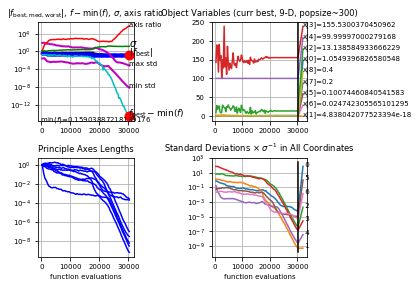

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0549914838120054, 2.057103915346106e-18, 13.138586809721478, 155.53003681945498, 99.99997001295667, 0.10077457576250326, 0.024738566668466456, 0.2, 0.4]
std deviation: [0.000631117950477037, 6.8047719018257725e-09, 5.466651321258738e-06, 1.9059193334518643e-06, 3.186847184876549e-08, 0.00015002391389752992, 6.472877747972701e-05]


CMAEvolutionStrategyResult(xbest=array([1.05493968e+00, 4.83804208e-18, 1.31385849e+01, 1.55530037e+02,
       9.99999700e+01, 1.00744608e-01, 2.47423056e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139176, evals_best=30167, evaluations=30300, iterations=101, xfavorite=array([ 1.05499148e+00, -5.00000006e-02,  1.31385868e+01,  1.55530037e+02,
        1.00000187e+02,  4.27625424e-01,  2.03399839e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.31117950e-04, 6.80477190e-09, 5.46665132e-06, 1.90591933e-06,
       3.18684718e-08, 1.50023914e-04, 6.47287775e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05493968e+00 4.83804208e-18 1.31385849e+01 1.55530037e+02
 9.99999700e+01 1.00744608e-01 2.47423056e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139176


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test1


8

21

321

Test: 2
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=670336, Sat May 22 07:11:08 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.219320439135978e-01 1.0e+00 9.33e-01  3e-02  5e+01 0:01.1
    2    600 3.332698111896373e-01 4.4e+00 9.73e-01  2e-02  6e+01 0:02.1
    3    900 3.199485745120946e-01 9.9e+00 9.66e-01  2e-02  5e+01 0:03.2
    6   1800 3.289878792454002e-01 4.3e+01 1.10e+00  2e-02  5e+01 0:06.5
   10   3000 3.205303991908119e-01 7.1e+01 1.14e+00  1e-02  4e+01 0:10.8
   15   4500 2.552275527132739e-01 8.4e+01 1.29e+00  1e-02  2e+01 0:16.6
   21   6300 2.395457671371158e-01 7.7e+01 1.33e+00  1e-02  2e+01 0:23.4
   28   8400 2.152232970783842e-01 5.8e+01 1.41e+00  1e-02  1e+01 0:31.1
   36  10800 1.932328805381156e-01 5.7e+01 2.06e+00  7e-03  6e+00 0:40.2
   44  13200 1.649812346049870e-01 1.7e+02 7.45e+00  1e-03  2e+00 0:49.4
   53  15900 1.591952276628943e-01 1.4e+02 1.36e+01  5e-04  1e+00 0:59.6
   63  18900 1.59038898

32

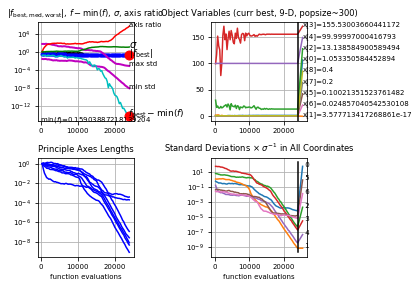

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0541754508854446, 3.5550302802581346e-20, 13.138586550478154, 155.5300366928564, 99.99997001666866, 0.10072993249686635, 0.024797460115092818, 0.2, 0.4]
std deviation: [0.000693057834330143, 7.859251396384819e-09, 5.6419347313674836e-06, 2.0932224709747085e-06, 4.0536686293754944e-08, 0.00018363036371479388, 7.105408162247325e-05]


CMAEvolutionStrategyResult(xbest=array([1.05335058e+00, 3.57771342e-17, 1.31385849e+01, 1.55530037e+02,
       9.99999700e+01, 1.00213515e-01, 2.48570405e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139204, evals_best=23894, evaluations=24000, iterations=80, xfavorite=array([ 1.05417545e+00, -4.99999999e-02,  1.31385866e+01,  1.55530037e+02,
        1.00000187e+02,  1.00729932e-01,  2.04236610e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.93057834e-04, 7.85925140e-09, 5.64193473e-06, 2.09322247e-06,
       4.05366863e-08, 1.83630364e-04, 7.10540816e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05335058e+00 3.57771342e-17 1.31385849e+01 1.55530037e+02
 9.99999700e+01 1.00213515e-01 2.48570405e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139204


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test2


8

21

321

Test: 3
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=675754, Sat May 22 07:12:40 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.104527675932442e-01 1.0e+00 9.96e-01  3e-02  5e+01 0:01.1
    2    600 3.344832442642049e-01 4.0e+00 9.77e-01  3e-02  5e+01 0:02.2
    3    900 3.105189705285588e-01 1.2e+01 1.03e+00  3e-02  5e+01 0:03.3
    6   1800 2.915301053228423e-01 4.4e+01 1.23e+00  2e-02  5e+01 0:06.6
   10   3000 2.619929242705258e-01 1.3e+02 1.37e+00  1e-02  4e+01 0:11.5
   15   4500 2.966151503689496e-01 1.6e+02 1.43e+00  8e-03  2e+01 0:17.4
   21   6300 2.558396093347381e-01 1.9e+02 1.54e+00  1e-02  1e+01 0:24.4
   28   8400 2.471462182360886e-01 2.4e+02 1.80e+00  7e-03  8e+00 0:32.3
   35  10500 2.611305363915363e-01 2.4e+02 2.03e+00  7e-03  8e+00 0:40.5
   43  12900 2.334614780096110e-01 2.1e+02 2.28e+00  5e-03  6e+00 0:49.7
   52  15600 1.942949484824661e-01 4.0e+02 3.45e+00  8e-03  5e+00 0:59.9
   62  18600 1.68748514

33

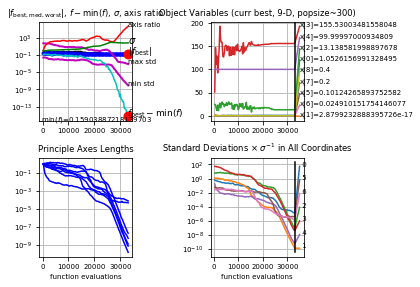

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.052122435288642, 3.990614652873337e-18, 13.138586751150434, 155.53003701215883, 99.99997001363882, 0.10096546470617551, 0.024945828147260075, 0.2, 0.4]
std deviation: [0.0008109211765771268, 8.80399932290597e-09, 6.597838713059536e-06, 2.641093258014349e-06, 3.746562730542937e-08, 0.00026443076325856606, 8.304973275085725e-05]


CMAEvolutionStrategyResult(xbest=array([1.05261570e+00, 2.87992329e-17, 1.31385820e+01, 1.55530035e+02,
       9.99999700e+01, 1.01242659e-01, 2.49101518e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139703, evals_best=32854, evaluations=33000, iterations=110, xfavorite=array([ 1.05212244e+00, -5.00000009e-02,  4.99614132e+01,  1.55530037e+02,
        1.00000187e+02,  4.27434535e-01,  2.06340260e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.10921177e-04, 8.80399932e-09, 6.59783871e-06, 2.64109326e-06,
       3.74656273e-08, 2.64430763e-04, 8.30497328e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05261570e+00 2.87992329e-17 1.31385820e+01 1.55530035e+02
 9.99999700e+01 1.01242659e-01 2.49101518e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139703


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test3


8

21

321

Test: 4
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=823840, Sat May 22 07:14:50 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.334013244385551e-01 1.0e+00 1.01e+00  3e-02  6e+01 0:01.1
    2    600 3.264967420963006e-01 4.5e+00 1.11e+00  3e-02  5e+01 0:02.2
    3    900 2.678639339976012e-01 1.4e+01 1.15e+00  3e-02  5e+01 0:03.3
    6   1800 3.026912484078132e-01 5.6e+01 1.14e+00  1e-02  3e+01 0:06.5
   10   3000 3.047511200683711e-01 1.7e+02 1.27e+00  9e-03  3e+01 0:10.8
   15   4500 2.737043234993971e-01 2.0e+02 1.46e+00  8e-03  2e+01 0:16.6
   21   6300 2.420318740824597e-01 2.9e+02 1.37e+00  6e-03  1e+01 0:23.5
   28   8400 2.442656412026490e-01 4.9e+02 1.32e+00  4e-03  7e+00 0:31.2
   35  10500 2.453773221032481e-01 4.3e+02 1.28e+00  2e-03  5e+00 0:39.3
   43  12900 2.295775804743017e-01 3.3e+02 1.63e+00  2e-03  6e+00 0:48.3
   52  15600 1.733419174977164e-01 5.7e+02 1.93e+00  2e-03  8e+00 0:58.4
   62  18600 9.67905082

33

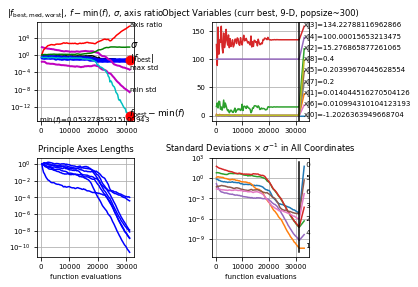

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.202721692926163, 0.014044517026770434, 15.276868152746347, 134.2278838879505, 100.00015650092533, 0.20399882796081434, 0.010989664937344256, 0.2, 0.4]
std deviation: [0.00038949059406210933, 2.5254753577029218e-09, 3.1215928205865785e-06, 3.5700003202095276e-06, 3.621603612515108e-08, 0.0003219577698121639, 4.5212936361868535e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20263639e+00,  1.40445163e-02,  1.52768659e+01,  1.34227881e+02,
        1.00000157e+02,  2.03996704e-01,  1.09943101e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.05327859215100943, evals_best=31087, evaluations=31200, iterations=104, xfavorite=array([-1.20272169e+00, -1.02999089e-01,  1.52768682e+01,  1.34227884e+02,
        1.00000376e+02,  2.64731250e-01, -3.11788201e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([3.89490594e-04, 2.52547536e-09, 3.12159282e-06, 3.57000032e-06,
       3.62160361e-08, 3.21957770e-04, 4.52129364e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20263639e+00  1.40445163e-02  1.52768659e+01  1.34227881e+02
  1.00000157e+02  2.03996704e-01  1.09943101e-02  2.00000000e-01
  4.00000000e-01]
error = 0.05327859215100943


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test4


8

21

321

Test: 5
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=714902, Sat May 22 07:16:49 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.512609138021529e-01 1.0e+00 1.08e+00  3e-02  7e+01 0:01.1
    2    600 3.031616447878684e-01 4.4e+00 1.06e+00  3e-02  8e+01 0:02.2
    3    900 3.341651294056872e-01 1.3e+01 1.09e+00  3e-02  8e+01 0:03.3
    6   1800 3.166167373378856e-01 1.1e+02 1.15e+00  1e-02  6e+01 0:06.7
   10   3000 3.116353806698315e-01 2.7e+02 1.11e+00  5e-03  4e+01 0:11.1
   15   4500 3.091699560512792e-01 2.7e+02 1.26e+00  4e-03  3e+01 0:16.9
   21   6300 2.995564916367697e-01 3.1e+02 1.33e+00  4e-03  2e+01 0:23.9
   28   8400 2.758322898850544e-01 4.4e+02 1.46e+00  4e-03  1e+01 0:31.8
   35  10500 2.432674778189672e-01 3.3e+02 1.67e+00  3e-03  8e+00 0:40.0
   43  12900 2.464910037509976e-01 3.1e+02 1.54e+00  2e-03  5e+00 0:49.2
   52  15600 2.181588174059281e-01 3.2e+02 1.91e+00  2e-03  3e+00 0:59.5
   62  18600 2.67979747

32

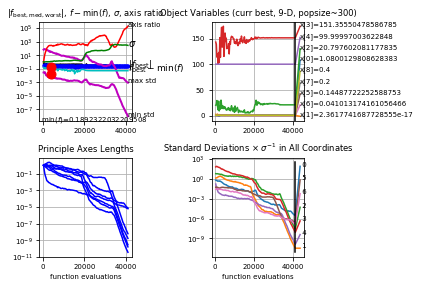

termination on tolfun=1e-11
final/bestever f-value = 2.422084e-01 1.892322e-01
incumbent solution: [1.0796213021774252, 1.4698186482150577e-18, 20.797597628578792, 151.35550436595972, 99.99997001679887, 0.14493946195784993, 0.04103061996791482, 0.2, 0.4]
std deviation: [0.000897096594795481, 9.74345629829538e-09, 7.787418743633535e-06, 2.4041709093896204e-06, 3.773316938077718e-08, 9.869810643961473e-05, 4.410696442311768e-05]


CMAEvolutionStrategyResult(xbest=array([7.70688922e-01, 1.67860505e-01, 1.88311062e+01, 1.33974541e+02,
       9.99984543e+01, 1.80981699e-01, 5.61217054e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.1892322032209508, evals_best=3606, evaluations=41100, iterations=137, xfavorite=array([ 1.07962130e+00, -4.99999995e-02,  2.07975976e+01,  1.51355504e+02,
        1.00000187e+02,  3.83455094e-01,  4.05876592e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.97096595e-04, 9.74345630e-09, 7.78741874e-06, 2.40417091e-06,
       3.77331694e-08, 9.86981064e-05, 4.41069644e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [7.70688922e-01 1.67860505e-01 1.88311062e+01 1.33974541e+02
 9.99984543e+01 1.80981699e-01 5.61217054e-02 2.00000000e-01
 4.00000000e-01]
error = 0.1892322032209508


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test5


8

21

321

Test: 6
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=783756, Sat May 22 07:19:29 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.381043322799193e-01 1.0e+00 1.05e+00  3e-02  6e+01 0:01.2
    2    600 3.434015208736992e-01 4.7e+00 1.13e+00  3e-02  7e+01 0:02.5
    3    900 3.150776726837089e-01 1.7e+01 1.21e+00  3e-02  7e+01 0:03.6
    6   1800 3.226091388634860e-01 7.9e+01 1.32e+00  1e-02  7e+01 0:07.2
   10   3000 2.876000609342372e-01 2.0e+02 1.38e+00  7e-03  5e+01 0:11.5
   15   4500 3.194988273367615e-01 2.3e+02 1.71e+00  8e-03  4e+01 0:17.4
   21   6300 2.503625506151556e-01 4.3e+02 1.67e+00  5e-03  2e+01 0:24.7
   28   8400 1.985598640865514e-01 5.5e+02 1.74e+00  6e-03  9e+00 0:32.5
   35  10500 2.307519539628480e-01 4.8e+02 1.85e+00  5e-03  8e+00 0:40.6
   43  12900 1.781911653146262e-01 4.0e+02 3.06e+00  3e-03  5e+00 0:49.9
   52  15600 1.601570404734628e-01 1.8e+02 7.59e+00  1e-03  2e+00 1:00.5
   62  18600 1.59053924

33

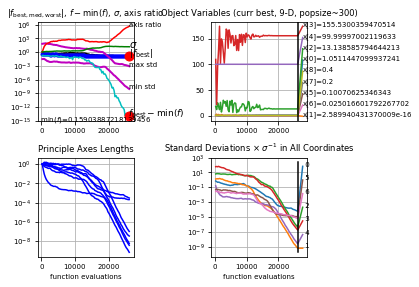

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0513606737598933, 1.224695778238086e-17, 13.13858598593346, 155.53003679557506, 99.9999700185695, 0.10081729519973504, 0.02500095196199351, 0.2, 0.4]
std deviation: [0.0008114181720086967, 8.92659080719125e-09, 6.135837191164372e-06, 2.526947393757092e-06, 3.5501199502039196e-08, 0.00017806096925507834, 8.307743093242274e-05]


CMAEvolutionStrategyResult(xbest=array([1.05114471e+00, 2.58994043e-16, 1.31385858e+01, 1.55530036e+02,
       9.99999700e+01, 1.00706253e-01, 2.50166018e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139456, evals_best=25842, evaluations=26100, iterations=87, xfavorite=array([ 1.05136067e+00, -4.99999984e-02,  1.31385860e+01,  1.55530037e+02,
        1.00000187e+02,  1.00817295e-01,  2.07120244e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.11418172e-04, 8.92659081e-09, 6.13583719e-06, 2.52694739e-06,
       3.55011995e-08, 1.78060969e-04, 8.30774309e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05114471e+00 2.58994043e-16 1.31385858e+01 1.55530036e+02
 9.99999700e+01 1.00706253e-01 2.50166018e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139456


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test6


8

21

321

Test: 7
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=729771, Sat May 22 07:21:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.341473270242416e-01 1.0e+00 1.15e+00  3e-02  7e+01 0:01.1
    2    600 2.974364346846713e-01 4.6e+00 1.12e+00  3e-02  7e+01 0:02.3
    3    900 2.925335871000379e-01 1.2e+01 1.13e+00  3e-02  8e+01 0:03.4
    6   1800 2.555944825372218e-01 7.3e+01 1.06e+00  1e-02  6e+01 0:06.8
   10   3000 2.959263831625115e-01 8.4e+01 1.23e+00  1e-02  5e+01 0:11.3
   14   4200 3.076854992697032e-01 1.4e+02 1.37e+00  9e-03  3e+01 0:16.3
   20   6000 2.885969068305811e-01 1.2e+02 1.28e+00  6e-03  1e+01 0:23.1
   27   8100 2.496356218055039e-01 1.3e+02 1.66e+00  7e-03  1e+01 0:31.0
   34  10200 2.159958464176068e-01 7.5e+01 2.02e+00  1e-02  1e+01 0:39.1
   42  12600 1.903917133376707e-01 7.9e+01 1.96e+00  9e-03  8e+00 0:48.3
   51  15300 1.536163821590927e-01 1.3e+02 2.04e+00  4e-03  5e+00 0:58.5
   61  18300 1.13937859

33

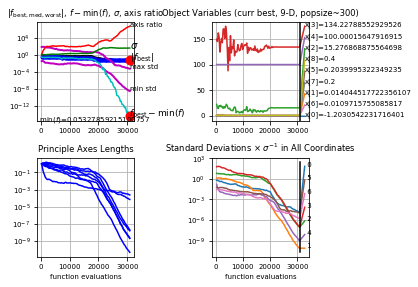

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2033052188529527, 0.014044516548983163, 15.276869004634989, 134.22788210169375, 100.00015650548224, 0.20399998528936145, 0.010957912635056613, 0.2, 0.4]
std deviation: [0.000518941686117803, 3.011425201457281e-09, 3.3629876293878083e-06, 3.9804299642044686e-06, 3.882413391271637e-08, 0.00042697463248469433, 6.0297628277083966e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20305422e+00,  1.40445177e-02,  1.52768689e+01,  1.34227886e+02,
        1.00000156e+02,  2.03999532e-01,  1.09715755e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.05327859215100757, evals_best=30644, evaluations=30900, iterations=103, xfavorite=array([-1.20330522e+00, -1.02999088e-01,  1.52768690e+01,  1.34227882e+02,
        1.00000376e+02,  2.64259517e-01, -3.18565896e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([5.18941686e-04, 3.01142520e-09, 3.36298763e-06, 3.98042996e-06,
       3.88241339e-08, 4.26974632e-04, 6.02976283e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20305422e+00  1.40445177e-02  1.52768689e+01  1.34227886e+02
  1.00000156e+02  2.03999532e-01  1.09715755e-02  2.00000000e-01
  4.00000000e-01]
error = 0.05327859215100757


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test7


8

21

321

Test: 8
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=805990, Sat May 22 07:23:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.435883686998309e-01 1.0e+00 9.48e-01  3e-02  6e+01 0:01.1
    2    600 3.073750551361145e-01 4.4e+00 9.58e-01  3e-02  6e+01 0:02.2
    3    900 2.089799880071952e-01 9.4e+00 9.14e-01  3e-02  5e+01 0:03.3
    6   1800 3.156762968661881e-01 3.9e+01 9.52e-01  2e-02  3e+01 0:06.6
   10   3000 2.426853539988592e-01 8.8e+01 1.18e+00  2e-02  3e+01 0:11.0
   15   4500 2.604018393135286e-01 1.0e+02 1.34e+00  2e-02  2e+01 0:16.8
   21   6300 2.018154682907277e-01 1.3e+02 1.30e+00  1e-02  8e+00 0:23.8
   28   8400 2.146163572261203e-01 1.5e+02 1.45e+00  8e-03  7e+00 0:31.6
   35  10500 1.842867409666475e-01 2.0e+02 1.43e+00  7e-03  7e+00 0:39.9
   43  12900 1.803368700723930e-01 1.7e+02 1.55e+00  7e-03  6e+00 0:49.1
   52  15600 1.408580293431673e-01 2.9e+02 1.59e+00  7e-03  6e+00 0:59.6
   62  18600 1.37400330

33

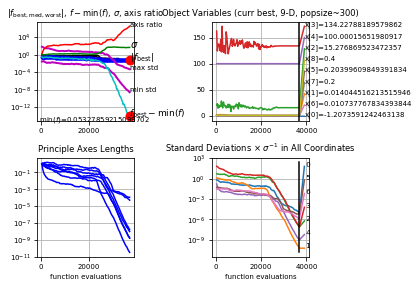

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2071904485350802, 0.014044516644492189, 15.27686871377973, 134.22788265220464, 100.00015650587144, 0.20399866793187607, 0.010746903434551478, 0.2, 0.4]
std deviation: [0.00043475606455652637, 2.4675323449233055e-09, 3.301910559914604e-06, 3.409676391772773e-06, 4.229067049758561e-08, 0.0002645339845639948, 5.083433608697491e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20735912e+00,  1.40445162e-02,  1.52768695e+01,  1.34227882e+02,
        1.00000157e+02,  2.03996098e-01,  1.07377678e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.05327859215099702, evals_best=36802, evaluations=36900, iterations=123, xfavorite=array([-1.20719045e+00,  2.99908800e-03,  1.52768687e+01,  1.34227883e+02,
        1.00000376e+02,  2.63633641e-01, -3.63858623e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.34756065e-04, 2.46753234e-09, 3.30191056e-06, 3.40967639e-06,
       4.22906705e-08, 2.64533985e-04, 5.08343361e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20735912e+00  1.40445162e-02  1.52768695e+01  1.34227882e+02
  1.00000157e+02  2.03996098e-01  1.07377678e-02  2.00000000e-01
  4.00000000e-01]
error = 0.05327859215099702


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test8


8

21

321

Test: 9
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=761594, Sat May 22 07:25:35 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.396654282773337e-01 1.0e+00 9.69e-01  2e-02  6e+01 0:01.1
    2    600 3.035228911081853e-01 4.4e+00 9.51e-01  3e-02  7e+01 0:02.2
    3    900 3.172161473571188e-01 1.2e+01 1.03e+00  3e-02  7e+01 0:03.3
    6   1800 3.097946495252622e-01 5.2e+01 1.11e+00  2e-02  6e+01 0:06.7
   10   3000 3.223618923756646e-01 7.5e+01 1.26e+00  1e-02  5e+01 0:11.2
   15   4500 2.701023910753577e-01 8.4e+01 1.54e+00  2e-02  3e+01 0:17.2
   21   6300 2.834576771362084e-01 9.8e+01 1.67e+00  1e-02  1e+01 0:24.1
   28   8400 2.229875025705813e-01 1.3e+02 1.96e+00  8e-03  7e+00 0:32.2
   35  10500 2.134550015694040e-01 1.4e+02 2.35e+00  9e-03  7e+00 0:40.7
   43  12900 1.846246144383104e-01 1.4e+02 2.41e+00  6e-03  5e+00 0:50.4
   52  15600 1.939852119610465e-01 2.0e+02 2.32e+00  5e-03  2e+00 1:01.0
   62  18600 1.81849439

32

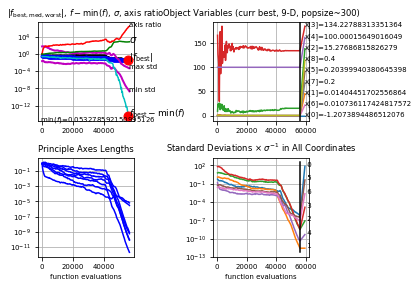

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2071199403686848, 0.014044516548785867, 15.276867955717348, 134.2278822743404, 100.00015650717752, 0.2039999881608655, 0.010750723381734101, 0.2, 0.4]
std deviation: [0.0005004493655929495, 2.1274331988146673e-09, 2.519593476525187e-06, 2.620615203395475e-06, 3.278405674632695e-08, 0.00025119117685096855, 5.852957733171621e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20774396e+00,  1.40445162e-02,  1.52768676e+01,  1.34227882e+02,
        1.00000157e+02,  2.03999995e-01,  1.07169022e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.053278592150995126, evals_best=55441, evaluations=56100, iterations=187, xfavorite=array([-1.20711994e+00, -1.02999088e-01,  1.52768680e+01,  1.34227882e+02,
        1.00000376e+02,  2.64146607e-01, -3.63034746e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([5.00449366e-04, 2.12743320e-09, 2.51959348e-06, 2.62061520e-06,
       3.27840567e-08, 2.51191177e-04, 5.85295773e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20774396e+00  1.40445162e-02  1.52768676e+01  1.34227882e+02
  1.00000157e+02  2.03999995e-01  1.07169022e-02  2.00000000e-01
  4.00000000e-01]
error = 0.053278592150995126


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test9


9

21

321

Test: 10
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=770807, Sat May 22 07:29:16 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.462885149023922e-01 1.0e+00 1.02e+00  3e-02  6e+01 0:01.1
    2    600 3.145761021037423e-01 4.0e+00 1.00e+00  3e-02  6e+01 0:02.2
    3    900 2.911813622064767e-01 1.3e+01 1.02e+00  3e-02  6e+01 0:03.4
    6   1800 2.817240977252435e-01 5.7e+01 1.08e+00  1e-02  4e+01 0:06.8
   10   3000 3.010372555836853e-01 8.7e+01 1.43e+00  1e-02  4e+01 0:11.2
   15   4500 2.735593275466365e-01 1.3e+02 1.61e+00  1e-02  2e+01 0:17.3
   21   6300 2.457682129149383e-01 1.5e+02 1.52e+00  7e-03  1e+01 0:24.4
   28   8400 2.200762832667619e-01 1.4e+02 1.38e+00  5e-03  7e+00 0:32.2
   35  10500 2.340590011067641e-01 1.3e+02 1.38e+00  4e-03  5e+00 0:40.3
   43  12900 1.953229670360621e-01 1.1e+02 3.63e+00  9e-03  5e+00 0:49.5
   52  15600 1.608488550685168e-01 1.3e+02 1.30e+01  2e-03  3e+00 1:00.1
   62  18600 1.5904464

32

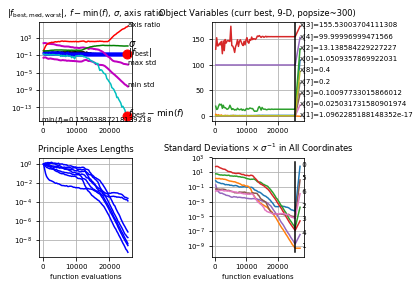

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0513069808486302, 4.130181699144327e-20, 13.138586856542164, 155.5300367699275, 99.99997000872011, 0.10095204996827749, 0.025004846105567198, 0.2, 0.4]
std deviation: [0.0007049974016374494, 6.451841840067821e-09, 3.824063005595605e-06, 1.7237095907333242e-06, 2.4413828639841536e-08, 9.893750236399966e-05, 7.216976994623537e-05]


CMAEvolutionStrategyResult(xbest=array([1.05049535e+00, 5.24464002e-17, 1.31385865e+01, 1.55530038e+02,
       9.99999700e+01, 1.01024076e-01, 2.50636394e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139218, evals_best=24998, evaluations=25500, iterations=85, xfavorite=array([ 1.05130698e+00, -5.00000001e-02,  1.31385869e+01,  1.55530037e+02,
        1.00000187e+02,  1.00952050e-01,  2.07175312e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([7.04997402e-04, 6.45184184e-09, 3.82406301e-06, 1.72370959e-06,
       2.44138286e-08, 9.89375024e-05, 7.21697699e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05049535e+00 5.24464002e-17 1.31385865e+01 1.55530038e+02
 9.99999700e+01 1.01024076e-01 2.50636394e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139218


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test10


9

21

321

Test: 11
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=844625, Sat May 22 07:30:56 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.493477006550696e-01 1.0e+00 9.83e-01  3e-02  6e+01 0:01.1
    2    600 3.363289830264174e-01 4.6e+00 1.01e+00  3e-02  6e+01 0:02.2
    3    900 3.129000885550750e-01 1.2e+01 9.94e-01  3e-02  6e+01 0:03.2
    6   1800 2.662627456185831e-01 6.8e+01 1.05e+00  1e-02  5e+01 0:06.5
   10   3000 2.974693766290473e-01 1.6e+02 1.10e+00  9e-03  3e+01 0:10.9
   15   4500 2.817420982629093e-01 1.7e+02 1.23e+00  8e-03  2e+01 0:16.7
   21   6300 2.327889829618251e-01 1.7e+02 1.21e+00  6e-03  1e+01 0:23.9
   28   8400 2.524033122450223e-01 2.0e+02 1.17e+00  5e-03  6e+00 0:31.7
   35  10500 2.275370574115711e-01 1.4e+02 1.69e+00  7e-03  6e+00 0:40.0
   43  12900 1.761555210088742e-01 3.2e+02 7.78e+00  4e-03  6e+00 0:49.1
   52  15600 1.602195996585823e-01 2.3e+02 1.51e+01  6e-04  2e+00 0:59.3
   62  18600 1.5905053

32

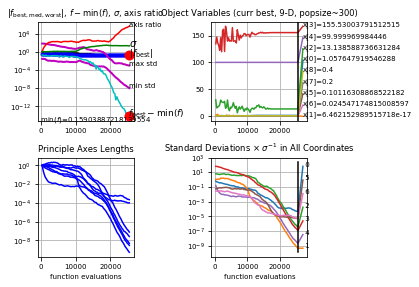

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0561222642679193, 2.0340517183533327e-17, 13.138587128271142, 155.53003757017947, 99.99997001473915, 0.10098278799468349, 0.024657020685947034, 0.2, 0.4]
std deviation: [0.0009622288377616367, 9.999383360920936e-09, 7.549342956329573e-06, 2.541694525310289e-06, 4.6704806806850615e-08, 0.00012588713235251963, 9.874416637091744e-05]


CMAEvolutionStrategyResult(xbest=array([1.05764792e+00, 6.46215299e-17, 1.31385887e+01, 1.55530038e+02,
       9.99999700e+01, 1.01163089e-01, 2.45471748e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139554, evals_best=25353, evaluations=25500, iterations=85, xfavorite=array([ 1.05612226e+00, -4.99999980e-02, -3.73858713e+00,  1.55530038e+02,
        1.00000187e+02,  1.00982788e-01,  2.02239570e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([9.62228838e-04, 9.99938336e-09, 7.54934296e-06, 2.54169453e-06,
       4.67048068e-08, 1.25887132e-04, 9.87441664e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05764792e+00 6.46215299e-17 1.31385887e+01 1.55530038e+02
 9.99999700e+01 1.01163089e-01 2.45471748e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139554


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test11


9

21

321

Test: 12
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=808255, Sat May 22 07:32:35 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.186050840074737e-01 1.0e+00 9.51e-01  2e-02  6e+01 0:01.1
    2    600 3.195687805291308e-01 4.2e+00 9.35e-01  2e-02  6e+01 0:02.3
    3    900 2.962277880024660e-01 1.0e+01 9.12e-01  2e-02  5e+01 0:03.4
    6   1800 3.125478610917856e-01 2.0e+01 9.93e-01  3e-02  4e+01 0:06.8
   10   3000 2.708324239389371e-01 7.4e+01 1.20e+00  2e-02  2e+01 0:11.4
   15   4500 2.684211252497752e-01 8.2e+01 1.11e+00  1e-02  1e+01 0:17.4
   21   6300 2.510365669254634e-01 1.1e+02 1.19e+00  8e-03  1e+01 0:24.3
   28   8400 2.612797753987838e-01 1.1e+02 1.56e+00  7e-03  1e+01 0:32.1
   35  10500 2.388906591966473e-01 1.4e+02 1.59e+00  5e-03  1e+01 0:40.3
   43  12900 2.145257247378664e-01 1.4e+02 1.70e+00  4e-03  5e+00 0:49.6
   52  15600 1.640695102705406e-01 1.0e+02 5.60e+00  5e-03  4e+00 1:00.2
   62  18600 1.5940797

33

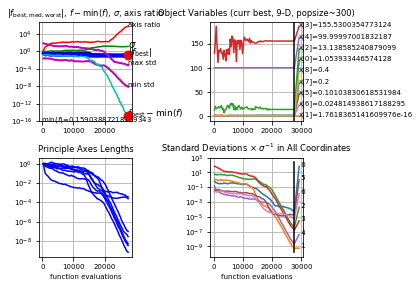

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.054543445476469, 1.5658880002273362e-18, 13.138585452561786, 155.53003672851426, 99.99997001144658, 0.10093937737983524, 0.024770893150043605, 0.2, 0.4]
std deviation: [0.0006422184973916388, 7.109365171355752e-09, 4.685649016310012e-06, 1.9703330560306622e-06, 2.8995134322248843e-08, 0.00024018840945905242, 6.585409213499946e-05]


CMAEvolutionStrategyResult(xbest=array([1.05393345e+00, 1.76183651e-16, 1.31385852e+01, 1.55530035e+02,
       9.99999700e+01, 1.01038306e-01, 2.48149386e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139343, evals_best=27479, evaluations=27600, iterations=92, xfavorite=array([ 1.05454345e+00, -5.00000006e-02,  1.31385855e+01,  1.55530037e+02,
        1.00000187e+02,  1.00939377e-01,  2.03859264e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.42218497e-04, 7.10936517e-09, 4.68564902e-06, 1.97033306e-06,
       2.89951343e-08, 2.40188409e-04, 6.58540921e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05393345e+00 1.76183651e-16 1.31385852e+01 1.55530035e+02
 9.99999700e+01 1.01038306e-01 2.48149386e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139343


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test12


9

21

321

Test: 13
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=763380, Sat May 22 07:34:24 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.306271031457079e-01 1.0e+00 1.03e+00  3e-02  7e+01 0:01.1
    2    600 3.364969056284089e-01 4.2e+00 1.12e+00  3e-02  7e+01 0:02.3
    3    900 3.209842698590931e-01 1.3e+01 1.17e+00  3e-02  7e+01 0:03.4
    6   1800 3.213376065284766e-01 5.1e+01 1.42e+00  1e-02  7e+01 0:06.9
   10   3000 2.656912645310067e-01 1.5e+02 1.44e+00  8e-03  3e+01 0:11.4
   14   4200 2.905191758573513e-01 1.4e+02 1.43e+00  8e-03  2e+01 0:16.4
   20   6000 1.700665171279910e-01 1.5e+02 1.53e+00  7e-03  1e+01 0:23.2
   27   8100 2.189238634165549e-01 1.2e+02 1.51e+00  6e-03  9e+00 0:31.2
   34  10200 2.596902965964427e-01 2.3e+02 1.64e+00  7e-03  9e+00 0:39.5
   42  12600 2.436722838090631e-01 2.1e+02 1.62e+00  5e-03  6e+00 0:48.8
   51  15300 2.439641285240732e-01 2.9e+02 2.07e+00  5e-03  6e+00 0:59.4
   61  18300 2.3536375

32

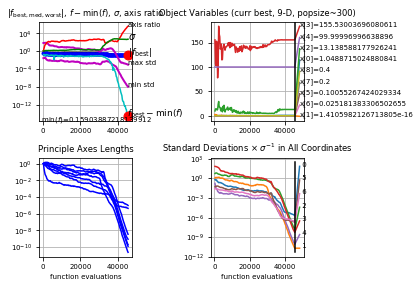

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0486538627210338, 5.548167739471531e-18, 13.138587765914087, 155.53003703146675, 99.9999700033468, 0.1007257112928347, 0.025197161487110736, 0.2, 0.4]
std deviation: [0.0009004178157896888, 1.0172038009612465e-08, 6.273053117719721e-06, 2.6514535418641446e-06, 4.0214664475210324e-08, 0.0001073753967188776, 9.206055027993196e-05]


CMAEvolutionStrategyResult(xbest=array([1.04887150e+00, 1.41059821e-16, 1.31385882e+01, 1.55530037e+02,
       9.99999700e+01, 1.00552674e-01, 2.51813833e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139912, evals_best=45463, evaluations=45600, iterations=152, xfavorite=array([ 1.04865386e+00, -4.99999989e-02,  1.31385878e+01,  1.55530037e+02,
        1.00000187e+02,  1.00725711e-01,  2.09889590e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([9.00417816e-04, 1.01720380e-08, 6.27305312e-06, 2.65145354e-06,
       4.02146645e-08, 1.07375397e-04, 9.20605503e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.04887150e+00 1.41059821e-16 1.31385882e+01 1.55530037e+02
 9.99999700e+01 1.00552674e-01 2.51813833e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139912


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test13


9

21

321

Test: 14
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=688490, Sat May 22 07:37:24 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.307510629192311e-01 1.0e+00 9.54e-01  2e-02  5e+01 0:01.1
    2    600 3.013769610693673e-01 4.4e+00 9.15e-01  2e-02  5e+01 0:02.2
    3    900 2.651295059402260e-01 1.5e+01 9.07e-01  2e-02  4e+01 0:03.3
    6   1800 3.125191673503578e-01 5.4e+01 1.05e+00  2e-02  3e+01 0:06.6
   10   3000 2.674230943556866e-01 9.3e+01 1.36e+00  2e-02  2e+01 0:10.9
   15   4500 2.759150458372392e-01 1.1e+02 1.32e+00  2e-02  2e+01 0:16.7
   21   6300 2.332252990913701e-01 9.5e+01 1.37e+00  1e-02  1e+01 0:23.7
   28   8400 2.601521559301041e-01 1.9e+02 1.21e+00  1e-02  1e+01 0:31.4
   35  10500 2.357093379990730e-01 2.3e+02 1.12e+00  1e-02  1e+01 0:39.8
   43  12900 2.477865068021746e-01 2.0e+02 1.31e+00  1e-02  7e+00 0:49.3
   52  15600 1.797218075208561e-01 2.0e+02 2.03e+00  9e-03  6e+00 0:59.5
   62  18600 1.6170852

33

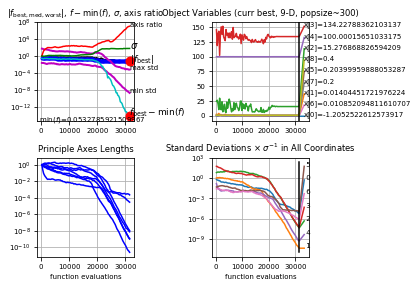

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.205269088998412, 0.014044516388824813, 15.276868672428298, 134.22788225636913, 100.00015650453821, 0.20399806183865996, 0.010851175011984685, 0.2, 0.4]
std deviation: [0.0003277882214817216, 2.378283494712412e-09, 2.365267873582912e-06, 2.901382505560426e-06, 2.8009751747295884e-08, 0.0006775501560036098, 3.8221652669306504e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20525226e+00,  1.40445172e-02,  1.52768688e+01,  1.34227884e+02,
        1.00000157e+02,  2.03999599e-01,  1.08520948e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.0532785921509967, evals_best=31417, evaluations=31500, iterations=105, xfavorite=array([-1.20526909e+00,  2.99908752e-03,  1.52768687e+01,  1.34227882e+02,
        1.00000376e+02,  2.63516839e-01, -3.41421888e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([3.27788221e-04, 2.37828349e-09, 2.36526787e-06, 2.90138251e-06,
       2.80097517e-08, 6.77550156e-04, 3.82216527e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20525226e+00  1.40445172e-02  1.52768688e+01  1.34227884e+02
  1.00000157e+02  2.03999599e-01  1.08520948e-02  2.00000000e-01
  4.00000000e-01]
error = 0.0532785921509967


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test14


9

21

321

Test: 15
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=677436, Sat May 22 07:39:27 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.470301201672215e-01 1.0e+00 1.10e+00  3e-02  6e+01 0:01.1
    2    600 2.764632724685334e-01 4.6e+00 1.14e+00  3e-02  6e+01 0:02.2
    3    900 3.220200897300284e-01 1.2e+01 1.15e+00  3e-02  6e+01 0:03.3
    6   1800 2.841027298756276e-01 7.3e+01 1.09e+00  8e-03  5e+01 0:06.7
   10   3000 2.899742393877622e-01 2.0e+02 1.28e+00  6e-03  4e+01 0:11.1
   15   4500 2.651825339600095e-01 4.3e+02 1.57e+00  6e-03  3e+01 0:17.1
   21   6300 2.050404804151692e-01 8.9e+02 1.69e+00  6e-03  2e+01 0:24.3
   28   8400 2.723977641421421e-01 6.1e+02 1.67e+00  4e-03  9e+00 0:32.4
   35  10500 2.345719353937712e-01 6.3e+02 1.79e+00  5e-03  5e+00 0:40.7
   43  12900 2.238154767376405e-01 8.4e+02 2.18e+00  6e-03  5e+00 0:49.9
   52  15600 2.207948939886128e-01 9.8e+02 1.98e+00  3e-03  4e+00 1:00.5
   62  18600 2.1560957

32

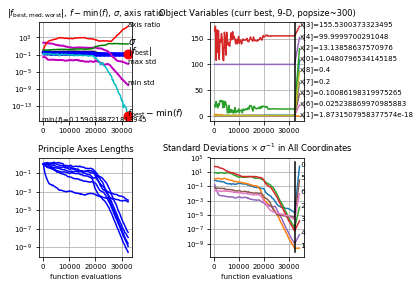

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.048735652652978, 1.6277622801233007e-17, 13.138586015324659, 155.53003739135295, 99.99997000833143, 0.10112093847023969, 0.025191232301218565, 0.2, 0.4]
std deviation: [0.0006760775412936173, 7.44647220272726e-09, 5.14136620456683e-06, 1.953707806526696e-06, 3.152128709386042e-08, 0.0001669722582878357, 6.912071693382837e-05]


CMAEvolutionStrategyResult(xbest=array([1.04807965e+00, 1.87315080e-18, 1.31385864e+01, 1.55530037e+02,
       9.99999700e+01, 1.00861983e-01, 2.52388700e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.1590388721813945, evals_best=32344, evaluations=32400, iterations=108, xfavorite=array([ 1.04873565e+00, -4.99999982e-02,  1.31385860e+01,  1.55530037e+02,
        1.00000187e+02,  1.01120938e-01,  2.09806062e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.76077541e-04, 7.44647220e-09, 5.14136620e-06, 1.95370781e-06,
       3.15212871e-08, 1.66972258e-04, 6.91207169e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.04807965e+00 1.87315080e-18 1.31385864e+01 1.55530037e+02
 9.99999700e+01 1.00861983e-01 2.52388700e-02 2.00000000e-01
 4.00000000e-01]
error = 0.1590388721813945


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test15


9

21

321

Test: 16
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=802917, Sat May 22 07:41:35 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.488030046848395e-01 1.0e+00 1.09e+00  3e-02  6e+01 0:01.2
    2    600 3.388259987337817e-01 4.8e+00 9.84e-01  3e-02  5e+01 0:02.3
    3    900 3.121648121463259e-01 1.3e+01 1.08e+00  3e-02  5e+01 0:03.4
    6   1800 3.141435809186551e-01 4.3e+01 1.08e+00  2e-02  3e+01 0:06.7
   10   3000 2.879108600778888e-01 6.9e+01 1.56e+00  2e-02  3e+01 0:11.3
   15   4500 2.727056925564028e-01 1.5e+02 1.92e+00  1e-02  2e+01 0:17.2
   21   6300 2.504475672648325e-01 1.3e+02 1.91e+00  1e-02  1e+01 0:24.2
   28   8400 2.360734263717691e-01 1.2e+02 2.41e+00  1e-02  1e+01 0:32.0
   35  10500 2.268635627257566e-01 1.6e+02 2.65e+00  1e-02  1e+01 0:40.1
   43  12900 2.284370352898603e-01 2.0e+02 2.68e+00  8e-03  8e+00 0:49.5
   52  15600 1.442210405813655e-01 1.9e+02 3.03e+00  8e-03  6e+00 0:59.9
   62  18600 1.5423711

33

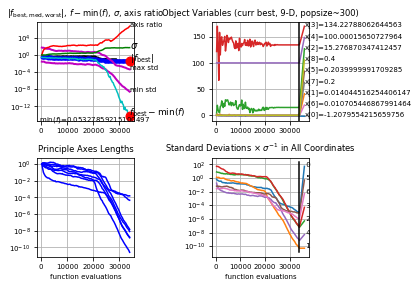

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2076243783541063, 0.014044516675155432, 15.276868994809208, 134.22788249634286, 100.00015650762609, 0.20399999949702932, 0.010723379402497513, 0.2, 0.4]
std deviation: [0.00046245345783753436, 2.809235263428808e-09, 3.2017712238060856e-06, 3.7739603064744524e-06, 3.739876236648542e-08, 0.0004204072254911534, 5.412903403809114e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20795542e+00,  1.40445163e-02,  1.52768703e+01,  1.34227881e+02,
        1.00000157e+02,  2.03999999e-01,  1.07054469e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.05327859215100497, evals_best=33733, evaluations=33900, iterations=113, xfavorite=array([-1.20762438e+00,  2.99908806e-03,  1.52768690e+01,  1.34227882e+02,
        1.00000376e+02,  2.64188995e-01, -3.68935457e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.62453458e-04, 2.80923526e-09, 3.20177122e-06, 3.77396031e-06,
       3.73987624e-08, 4.20407225e-04, 5.41290340e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20795542e+00  1.40445163e-02  1.52768703e+01  1.34227881e+02
  1.00000157e+02  2.03999999e-01  1.07054469e-02  2.00000000e-01
  4.00000000e-01]
error = 0.05327859215100497


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test16


9

21

321

Test: 17
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=734364, Sat May 22 07:43:48 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.317459159254044e-01 1.0e+00 9.80e-01  3e-02  6e+01 0:01.1
    2    600 3.286226450913888e-01 4.5e+00 1.03e+00  3e-02  6e+01 0:02.2
    3    900 3.232848118080964e-01 1.2e+01 1.00e+00  3e-02  5e+01 0:03.3
    6   1800 3.121656432033920e-01 5.3e+01 9.72e-01  1e-02  3e+01 0:06.6
   10   3000 2.760085251913416e-01 1.1e+02 1.09e+00  8e-03  2e+01 0:11.1
   15   4500 2.839294481030956e-01 1.0e+02 1.25e+00  1e-02  2e+01 0:17.0
   21   6300 2.623472122954106e-01 7.1e+01 1.38e+00  1e-02  1e+01 0:24.0
   28   8400 2.313846557343329e-01 1.3e+02 1.38e+00  1e-02  9e+00 0:31.8
   35  10500 2.442267315730162e-01 1.6e+02 1.56e+00  5e-03  6e+00 0:39.9
   43  12900 2.464067334819063e-01 2.1e+02 1.62e+00  4e-03  6e+00 0:49.2
   52  15600 1.850665689473332e-01 1.3e+02 5.72e+00  4e-03  7e+00 0:59.6
   62  18600 1.6205434

33

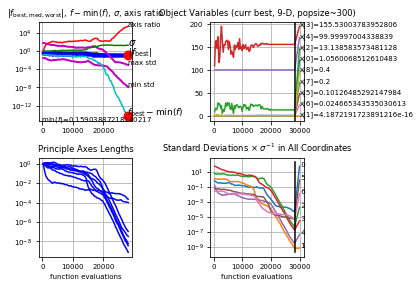

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0546513084593059, 1.0417256025530997e-17, 13.138585687450316, 155.53003681444395, 99.99997001037555, 0.10113174519999443, 0.024763103500320707, 0.2, 0.4]
std deviation: [0.0008834277022247344, 1.168441027075634e-08, 9.082735434004486e-06, 3.279113868141064e-06, 5.4986126720680375e-08, 0.00010778884549751242, 9.058588943111584e-05]


CMAEvolutionStrategyResult(xbest=array([1.05600685e+00, 4.18721917e-16, 1.31385836e+01, 1.55530038e+02,
       9.99999700e+01, 1.01264853e-01, 2.46653435e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218140217, evals_best=28063, evaluations=28200, iterations=94, xfavorite=array([ 2.29950869e+00, -4.99999986e-02,  4.99614143e+01,  1.55530037e+02,
        1.00000187e+02,  1.01131745e-01,  2.03748584e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.83427702e-04, 1.16844103e-08, 9.08273543e-06, 3.27911387e-06,
       5.49861267e-08, 1.07788845e-04, 9.05858894e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05600685e+00 4.18721917e-16 1.31385836e+01 1.55530038e+02
 9.99999700e+01 1.01264853e-01 2.46653435e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218140217


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test17


9

21

321

Test: 18
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=772605, Sat May 22 07:45:38 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.324431499915255e-01 1.0e+00 9.84e-01  3e-02  6e+01 0:01.1
    2    600 3.058444158394049e-01 4.0e+00 9.90e-01  3e-02  6e+01 0:02.2
    3    900 3.170387609445983e-01 1.2e+01 9.91e-01  3e-02  5e+01 0:03.3
    6   1800 2.589984374256769e-01 3.5e+01 1.08e+00  2e-02  4e+01 0:06.7
   10   3000 2.217598544977135e-01 7.8e+01 1.17e+00  1e-02  3e+01 0:11.2
   15   4500 2.883779802733174e-01 9.6e+01 1.22e+00  2e-02  2e+01 0:17.2
   21   6300 2.758516099449664e-01 1.0e+02 1.49e+00  1e-02  1e+01 0:24.5
   28   8400 2.539533991888633e-01 1.6e+02 1.40e+00  1e-02  9e+00 0:32.3
   35  10500 2.474583233869718e-01 2.0e+02 1.53e+00  1e-02  1e+01 0:40.5
   43  12900 2.475336587207473e-01 1.4e+02 1.61e+00  9e-03  7e+00 0:49.8
   52  15600 2.168614660487488e-01 8.2e+01 1.98e+00  1e-02  6e+00 1:00.4
   62  18600 1.7748515

33

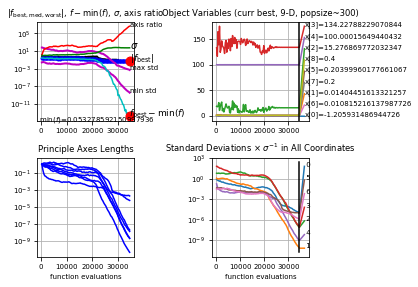

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2051966071450164, 0.014044516512796536, 15.276868848139207, 134.22788309060084, 100.00015649963532, 0.20399944269194653, 0.010855104133254639, 0.2, 0.4]
std deviation: [0.000509273557608124, 3.6000763721611756e-09, 4.075840228202162e-06, 4.404726119037458e-06, 4.774878594080458e-08, 0.0004871741458877531, 5.935884387361587e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20593149e+00,  1.40445161e-02,  1.52768698e+01,  1.34227882e+02,
        1.00000156e+02,  2.03999602e-01,  1.08152161e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.053278592150997936, evals_best=34436, evaluations=34500, iterations=115, xfavorite=array([-1.20519661e+00, -1.02999088e-01,  1.52768688e+01,  1.34227883e+02,
        1.00000376e+02,  2.64566333e-01, -3.40578548e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([5.09273558e-04, 3.60007637e-09, 4.07584023e-06, 4.40472612e-06,
       4.77487859e-08, 4.87174146e-04, 5.93588439e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20593149e+00  1.40445161e-02  1.52768698e+01  1.34227882e+02
  1.00000156e+02  2.03999602e-01  1.08152161e-02  2.00000000e-01
  4.00000000e-01]
error = 0.053278592150997936


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test18


9

21

321

Test: 19
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=682725, Sat May 22 07:47:53 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.228120356680013e-01 1.0e+00 9.96e-01  3e-02  6e+01 0:01.1
    2    600 3.324837372001351e-01 4.1e+00 9.95e-01  3e-02  5e+01 0:02.2
    3    900 3.178849336999076e-01 1.2e+01 1.00e+00  3e-02  5e+01 0:03.3
    6   1800 2.706327719357675e-01 3.2e+01 1.05e+00  3e-02  4e+01 0:06.5
   10   3000 2.369347269074663e-01 7.2e+01 1.46e+00  2e-02  3e+01 0:10.8
   15   4500 2.307260725332206e-01 1.3e+02 1.67e+00  2e-02  1e+01 0:16.8
   21   6300 2.373892920465507e-01 9.5e+01 1.67e+00  2e-02  1e+01 0:23.6
   28   8400 2.434152336169343e-01 1.2e+02 1.54e+00  1e-02  8e+00 0:31.2
   36  10800 2.261302192675932e-01 2.2e+02 1.32e+00  5e-03  3e+00 0:40.2
   45  13500 2.192300390394953e-01 2.3e+02 1.36e+00  6e-03  3e+00 0:50.2
   54  16200 2.439186951754885e-01 2.5e+02 1.54e+00  4e-03  2e+00 1:00.5
   64  19200 1.7022359

33

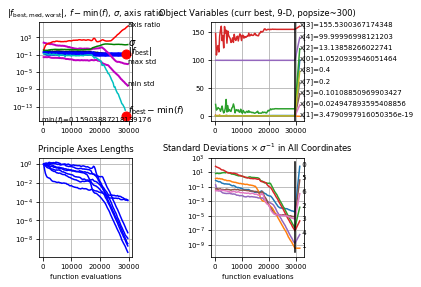

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0522309129007932, 1.3826795193605925e-17, 13.138585276892591, 155.53003653605018, 99.99997000973435, 0.10107015856423995, 0.024937985052384492, 0.2, 0.4]
std deviation: [0.0006656774829460514, 6.887521819206439e-09, 4.706579406144997e-06, 1.7376353241868215e-06, 3.3807768597860345e-08, 0.00016524964677773542, 6.818092652468639e-05]


CMAEvolutionStrategyResult(xbest=array([1.05286789e+00, 1.90522371e-16, 1.31385846e+01, 1.55530036e+02,
       9.99999700e+01, 1.00965771e-01, 2.48919305e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139176, evals_best=29062, evaluations=29700, iterations=99, xfavorite=array([ 1.05223091e+00, -4.99999983e-02, -3.73858528e+00,  1.55530037e+02,
        1.00000187e+02,  4.27329841e-01, -1.20622921e-01,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.65677483e-04, 6.88752182e-09, 4.70657941e-06, 1.73763532e-06,
       3.38077686e-08, 1.65249647e-04, 6.81809265e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05286789e+00 1.90522371e-16 1.31385846e+01 1.55530036e+02
 9.99999700e+01 1.00965771e-01 2.48919305e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139176


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test19


9

21

321

Test: 20
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=686463, Sat May 22 07:49:46 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.204942235237520e-01 1.0e+00 9.89e-01  2e-02  6e+01 0:01.1
    2    600 3.272780453573030e-01 4.4e+00 1.01e+00  2e-02  5e+01 0:02.2
    3    900 2.829570404322711e-01 1.2e+01 1.03e+00  2e-02  4e+01 0:03.3
    6   1800 3.031308119077882e-01 4.3e+01 1.13e+00  2e-02  5e+01 0:06.6
   10   3000 3.131134458933154e-01 7.1e+01 1.13e+00  1e-02  3e+01 0:10.9
   15   4500 2.858642517095185e-01 1.2e+02 1.58e+00  8e-03  2e+01 0:16.7
   21   6300 2.792686622862000e-01 1.2e+02 1.72e+00  8e-03  1e+01 0:23.5
   28   8400 2.534444403364128e-01 1.1e+02 1.83e+00  8e-03  9e+00 0:31.2
   35  10500 2.340096237125229e-01 7.0e+01 1.66e+00  8e-03  7e+00 0:39.3
   43  12900 1.940457997732150e-01 1.1e+02 1.74e+00  6e-03  7e+00 0:48.3
   52  15600 1.914418294212221e-01 9.2e+01 1.48e+00  5e-03  3e+00 0:58.4
   62  18600 1.9684112

32

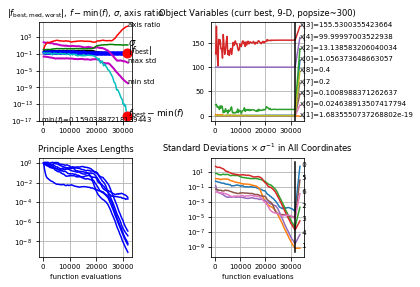

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0556216118556538, 4.772358256885504e-18, 13.138586916284241, 155.5300372560329, 99.99997001375543, 0.10094468455685607, 0.024693112943041266, 0.2, 0.4]
std deviation: [0.0008271544052575356, 9.826218943300796e-09, 6.465746385704096e-06, 2.648304490741656e-06, 3.821985029370786e-08, 0.0001321855465454681, 8.486112948788599e-05]


CMAEvolutionStrategyResult(xbest=array([1.05590812e+00, 2.99710350e-17, 1.31385852e+01, 1.55530036e+02,
       9.99999700e+01, 1.00872152e-01, 2.46724754e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139443, evals_best=31235, evaluations=31800, iterations=106, xfavorite=array([ 1.05562161e+00, -4.99999990e-02,  1.31385869e+01,  1.55530037e+02,
        1.00000187e+02,  1.00944685e-01,  2.02753341e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.27154405e-04, 9.82621894e-09, 6.46574639e-06, 2.64830449e-06,
       3.82198503e-08, 1.32185547e-04, 8.48611295e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05590812e+00 2.99710350e-17 1.31385852e+01 1.55530036e+02
 9.99999700e+01 1.00872152e-01 2.46724754e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139443


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test20


9

21

321

Test: 21
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=718370, Sat May 22 07:51:47 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.322763657778695e-01 1.0e+00 1.01e+00  2e-02  6e+01 0:01.1
    2    600 3.443885683065472e-01 4.3e+00 1.03e+00  3e-02  6e+01 0:02.2
    3    900 3.338482438032792e-01 1.3e+01 1.07e+00  3e-02  6e+01 0:03.3
    6   1800 3.161113974195315e-01 4.9e+01 1.05e+00  2e-02  4e+01 0:06.6
   10   3000 2.680091275903335e-01 9.5e+01 1.13e+00  1e-02  4e+01 0:10.9
   15   4500 2.964426230639809e-01 1.4e+02 1.58e+00  1e-02  2e+01 0:16.7
   21   6300 2.594465075978517e-01 1.1e+02 1.74e+00  1e-02  1e+01 0:23.5
   28   8400 2.411788840944883e-01 8.8e+01 1.65e+00  7e-03  8e+00 0:31.1
   36  10800 2.452814061071041e-01 9.5e+01 2.03e+00  9e-03  6e+00 0:40.2
   44  13200 2.402325764656139e-01 8.6e+01 2.24e+00  5e-03  4e+00 0:49.2
   53  15900 2.104300767748568e-01 5.3e+01 3.87e+00  7e-03  2e+00 0:59.4
   63  18900 1.6028696

33

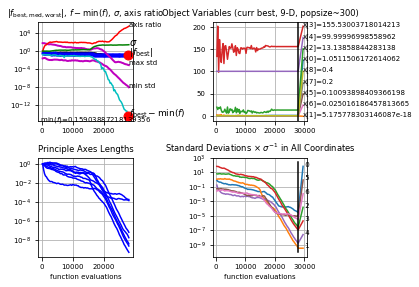

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0510871794473178, 1.2676326211169868e-18, 13.138587124667298, 155.53003651161808, 99.99997001633935, 0.10111388480610405, 0.02502075965023599, 0.2, 0.4]
std deviation: [0.0007845425083671532, 8.911408487168787e-09, 7.0358521611505045e-06, 3.0309780629746182e-06, 4.4234836619789366e-08, 0.0002460358756516866, 8.030137656413011e-05]


CMAEvolutionStrategyResult(xbest=array([1.05012279e+00, 1.67474255e-18, 1.31385897e+01, 1.55530036e+02,
       9.99999700e+01, 1.01206393e-01, 2.50906376e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139356, evals_best=27512, evaluations=27900, iterations=93, xfavorite=array([ 1.05108718e+00, -5.00000005e-02,  1.31385871e+01,  1.55530037e+02,
        1.00000187e+02,  1.01113885e-01,  2.07400306e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([7.84542508e-04, 8.91140849e-09, 7.03585216e-06, 3.03097806e-06,
       4.42348366e-08, 2.46035876e-04, 8.03013766e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05012279e+00 1.67474255e-18 1.31385897e+01 1.55530036e+02
 9.99999700e+01 1.01206393e-01 2.50906376e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139356


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test21


9

21

321

Test: 22
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=812616, Sat May 22 07:53:33 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.411364410987383e-01 1.0e+00 1.01e+00  2e-02  6e+01 0:01.1
    2    600 3.168197059817132e-01 3.6e+00 9.40e-01  3e-02  5e+01 0:02.2
    3    900 3.306580467364341e-01 1.0e+01 9.34e-01  2e-02  4e+01 0:03.3
    6   1800 3.107248506745474e-01 2.9e+01 1.08e+00  2e-02  3e+01 0:06.5
   10   3000 2.905671257166366e-01 7.0e+01 1.36e+00  1e-02  3e+01 0:10.9
   15   4500 2.606180823247006e-01 1.1e+02 1.35e+00  8e-03  2e+01 0:16.7
   21   6300 1.976949513075984e-01 1.7e+02 1.44e+00  6e-03  9e+00 0:23.7
   28   8400 1.955672032103830e-01 1.7e+02 1.35e+00  6e-03  7e+00 0:31.2
   36  10800 1.850459298627413e-01 2.0e+02 1.06e+00  4e-03  4e+00 0:40.2
   45  13500 1.569496372683165e-01 2.4e+02 1.06e+00  3e-03  3e+00 0:50.2
   54  16200 1.559052257823130e-01 3.3e+02 1.04e+00  4e-03  3e+00 1:00.3
   64  19200 6.8903368

33

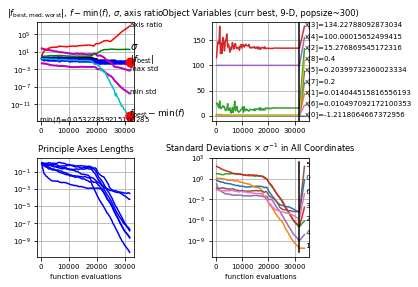

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.210857458953125, 0.014044516433775649, 15.276867858658344, 134.2278825317491, 100.00015650569411, 0.2039994541123531, 0.010548362298382796, 0.2, 0.4]
std deviation: [0.0004789041687501445, 3.151283329250768e-09, 4.009909487873043e-06, 4.467363295625121e-06, 3.921504238956246e-08, 0.0005478681459768905, 5.636714855995496e-05]


CMAEvolutionStrategyResult(xbest=array([-1.21180647e+00,  1.40445158e-02,  1.52768695e+01,  1.34227881e+02,
        1.00000157e+02,  2.03997324e-01,  1.04970922e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.05327859215100285, evals_best=31687, evaluations=31800, iterations=106, xfavorite=array([-1.21085746e+00, -1.02999088e-01,  1.52768679e+01,  1.34227883e+02,
        1.00000376e+02,  2.64562560e-01, -4.06882911e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.78904169e-04, 3.15128333e-09, 4.00990949e-06, 4.46736330e-06,
       3.92150424e-08, 5.47868146e-04, 5.63671486e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.21180647e+00  1.40445158e-02  1.52768695e+01  1.34227881e+02
  1.00000157e+02  2.03997324e-01  1.04970922e-02  2.00000000e-01
  4.00000000e-01]
error = 0.05327859215100285


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test22


9

21

321

Test: 23
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=842627, Sat May 22 07:55:34 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.275633068326141e-01 1.0e+00 1.03e+00  3e-02  7e+01 0:01.1
    2    600 3.470107480426798e-01 5.1e+00 1.08e+00  3e-02  7e+01 0:02.2
    3    900 3.255138230898290e-01 1.6e+01 1.10e+00  3e-02  7e+01 0:03.3
    6   1800 2.966891839706242e-01 6.6e+01 1.16e+00  2e-02  6e+01 0:06.5
   10   3000 2.808523572456125e-01 1.3e+02 1.46e+00  1e-02  5e+01 0:10.8
   15   4500 2.900028837736806e-01 1.2e+02 1.58e+00  1e-02  3e+01 0:16.6
   21   6300 2.009515954121480e-01 7.9e+01 1.79e+00  1e-02  1e+01 0:23.5
   28   8400 1.841159917091761e-01 8.1e+01 1.83e+00  1e-02  6e+00 0:31.1
   36  10800 1.701987125131791e-01 9.2e+01 1.53e+00  1e-02  4e+00 0:40.1
   45  13500 2.134071662171112e-01 1.1e+02 2.03e+00  9e-03  4e+00 0:50.2
   54  16200 2.136291915752795e-01 8.6e+01 3.89e+00  1e-02  3e+00 1:00.4
   64  19200 1.6928222

33

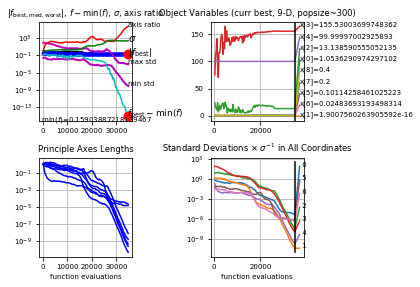

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.055155362315588, 4.85512428769147e-17, 13.138587357891433, 155.53003710393833, 99.9999700194164, 0.10119227593549537, 0.024726742160910517, 0.2, 0.4]
std deviation: [0.0008641623379089274, 7.853011652595936e-09, 6.094114592457692e-06, 2.205732489931077e-06, 3.330976090152562e-08, 0.00014926263793079233, 8.863481345347078e-05]


CMAEvolutionStrategyResult(xbest=array([1.05362910e+00, 1.90075603e-16, 1.31385906e+01, 1.55530037e+02,
       9.99999700e+01, 1.01142585e-01, 2.48369319e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139467, evals_best=34668, evaluations=34800, iterations=116, xfavorite=array([ 1.05515536e+00, -4.99999969e-02,  1.31385874e+01,  1.55530037e+02,
        1.00000187e+02,  1.01192276e-01,  2.03231714e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([8.64162338e-04, 7.85301165e-09, 6.09411459e-06, 2.20573249e-06,
       3.33097609e-08, 1.49262638e-04, 8.86348135e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05362910e+00 1.90075603e-16 1.31385906e+01 1.55530037e+02
 9.99999700e+01 1.01142585e-01 2.48369319e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139467


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test23


9

21

321

Test: 24
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=817734, Sat May 22 07:57:46 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.330842487052649e-01 1.0e+00 1.00e+00  2e-02  6e+01 0:01.1
    2    600 3.178809279960481e-01 3.6e+00 1.01e+00  2e-02  5e+01 0:02.3
    3    900 3.158981232403656e-01 9.6e+00 1.06e+00  2e-02  5e+01 0:03.4
    6   1800 3.093679843152003e-01 3.7e+01 1.06e+00  2e-02  3e+01 0:06.7
   10   3000 2.897137944246997e-01 5.9e+01 1.36e+00  2e-02  3e+01 0:11.1
   15   4500 2.690332006869990e-01 9.2e+01 1.59e+00  2e-02  2e+01 0:16.8
   21   6300 2.347365544006855e-01 7.8e+01 1.62e+00  2e-02  1e+01 0:23.9
   28   8400 2.333581892228840e-01 5.7e+01 1.92e+00  3e-02  8e+00 0:31.7
   35  10500 1.967406641635931e-01 7.9e+01 1.85e+00  2e-02  4e+00 0:39.9
   43  12900 1.915497966297394e-01 8.1e+01 1.87e+00  2e-02  3e+00 0:49.3
   52  15600 1.762032055807492e-01 8.4e+01 1.96e+00  2e-02  4e+00 0:59.9
   62  18600 1.6330436

32

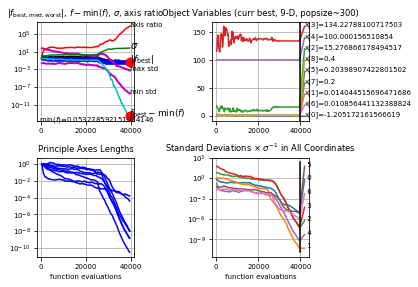

termination on tolfun=1e-11
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.206082197707078, 0.01404451692042424, 15.276867761688068, 134.22788321395564, 100.00015650051074, 0.2039932934312267, 0.010807018241204709, 0.2, 0.4]
std deviation: [0.0004838489884801414, 3.1049488021794833e-09, 3.016587998123668e-06, 4.147015658256577e-06, 3.9395753174354395e-08, 0.0005148320600817643, 5.648391651885015e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20517216e+00,  1.40445157e-02,  1.52768662e+01,  1.34227881e+02,
        1.00000157e+02,  2.03989074e-01,  1.08564411e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.053278592151004146, evals_best=39550, evaluations=39600, iterations=132, xfavorite=array([-1.20608220e+00, -1.02999089e-01,  1.52768678e+01,  1.34227883e+02,
        1.00000376e+02,  2.62929196e-01, -3.50910145e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.83848988e-04, 3.10494880e-09, 3.01658800e-06, 4.14701566e-06,
       3.93957532e-08, 5.14832060e-04, 5.64839165e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20517216e+00  1.40445157e-02  1.52768662e+01  1.34227881e+02
  1.00000157e+02  2.03989074e-01  1.08564411e-02  2.00000000e-01
  4.00000000e-01]
error = 0.053278592151004146


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test24


9

21

321

Test: 25
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=806894, Sat May 22 08:00:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 2.939843691615387e-01 1.0e+00 1.03e+00  3e-02  5e+01 0:01.1
    2    600 3.341820300981610e-01 4.3e+00 1.10e+00  3e-02  5e+01 0:02.2
    3    900 3.382587694542075e-01 1.2e+01 1.11e+00  3e-02  5e+01 0:03.3
    6   1800 3.257168921861425e-01 4.9e+01 1.12e+00  1e-02  4e+01 0:06.6
   10   3000 2.973161974698554e-01 8.0e+01 1.33e+00  1e-02  4e+01 0:11.0
   15   4500 2.887288282423132e-01 1.2e+02 1.51e+00  9e-03  3e+01 0:17.0
   21   6300 2.288239218146816e-01 2.1e+02 1.82e+00  7e-03  2e+01 0:24.1
   28   8400 2.719057736720078e-01 1.8e+02 2.03e+00  8e-03  1e+01 0:32.1
   35  10500 2.421859617182742e-01 2.7e+02 2.12e+00  7e-03  1e+01 0:40.8
   43  12900 2.129898444516140e-01 4.0e+02 2.25e+00  5e-03  9e+00 0:50.7
   52  15600 1.714386329626746e-01 1.9e+02 7.10e+00  5e-03  7e+00 1:01.7
   62  18600 1.5931214

33

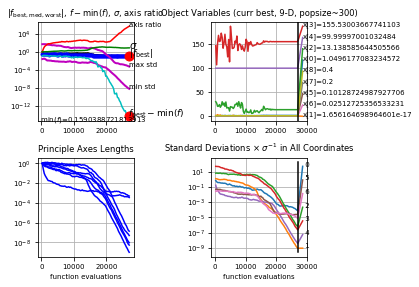

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0502297399877076, 7.965279660188181e-19, 13.138585853258993, 155.53003689366335, 99.99997001315242, 0.1010904070190701, 0.025082876625517794, 0.2, 0.4]
std deviation: [0.0006135848662386848, 7.3565046694856085e-09, 5.0978439719340775e-06, 1.8759629279247004e-06, 3.054161299123427e-08, 0.0001971994147265292, 6.2782878536337e-05]


CMAEvolutionStrategyResult(xbest=array([1.04961771e+00, 1.65616470e-17, 1.31385856e+01, 1.55530037e+02,
       9.99999700e+01, 1.01287250e-01, 2.51272536e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.1590388721813913, evals_best=26933, evaluations=27000, iterations=90, xfavorite=array([ 1.05022974e+00, -4.99999996e-02, -3.73858585e+00,  1.55530037e+02,
        1.00000187e+02,  1.01090407e-01,  2.08277864e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.13584866e-04, 7.35650467e-09, 5.09784397e-06, 1.87596293e-06,
       3.05416130e-08, 1.97199415e-04, 6.27828785e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.04961771e+00 1.65616470e-17 1.31385856e+01 1.55530037e+02
 9.99999700e+01 1.01287250e-01 2.51272536e-02 2.00000000e-01
 4.00000000e-01]
error = 0.1590388721813913


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test25


9

21

321

Test: 26
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=742686, Sat May 22 08:02:10 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.302845750586658e-01 1.0e+00 1.01e+00  3e-02  6e+01 0:01.1
    2    600 2.756566519995116e-01 4.1e+00 9.66e-01  2e-02  6e+01 0:02.2
    3    900 2.756673493528424e-01 1.2e+01 9.94e-01  2e-02  5e+01 0:03.3
    6   1800 3.154771556897950e-01 4.7e+01 9.92e-01  1e-02  4e+01 0:06.7
   10   3000 2.823063526032433e-01 7.4e+01 1.07e+00  8e-03  3e+01 0:11.1
   15   4500 2.747703915880821e-01 1.1e+02 1.19e+00  7e-03  3e+01 0:17.0
   21   6300 2.062086757817228e-01 2.1e+02 1.31e+00  4e-03  1e+01 0:23.9
   28   8400 2.331990777853163e-01 1.7e+02 1.33e+00  4e-03  6e+00 0:31.6
   35  10500 2.136565156108647e-01 1.5e+02 1.27e+00  4e-03  4e+00 0:39.7
   43  12900 1.936744101797663e-01 9.8e+01 2.62e+00  5e-03  4e+00 0:48.9
   52  15600 1.604698969377332e-01 2.2e+02 8.64e+00  2e-03  3e+00 0:59.2
   62  18600 1.5904865

32

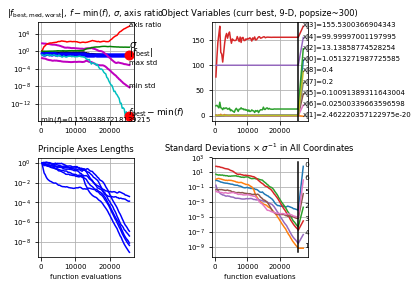

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0512087425591448, 1.9041262050970153e-17, 13.13858604695638, 155.5300368641925, 99.99997001641525, 0.10095019405302007, 0.025011958000216824, 0.2, 0.4]
std deviation: [0.0006944590461868645, 5.636366879871779e-09, 4.058682322250892e-06, 1.4572608488418236e-06, 2.5122295307973807e-08, 5.615393892565036e-05, 7.108947582918929e-05]


CMAEvolutionStrategyResult(xbest=array([1.05132720e+00, 2.46222036e-20, 1.31385877e+01, 1.55530037e+02,
       9.99999700e+01, 1.00913893e-01, 2.50033966e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139215, evals_best=25631, evaluations=25800, iterations=86, xfavorite=array([ 1.05120874e+00, -4.99999980e-02,  1.31385860e+01,  1.55530037e+02,
        1.00000187e+02,  1.00950194e-01,  2.07275873e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.94459046e-04, 5.63636688e-09, 4.05868232e-06, 1.45726085e-06,
       2.51222953e-08, 5.61539389e-05, 7.10894758e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05132720e+00 2.46222036e-20 1.31385877e+01 1.55530037e+02
 9.99999700e+01 1.00913893e-01 2.50033966e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139215


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test26


9

21

321

Test: 27
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=700474, Sat May 22 08:03:50 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.119746824111919e-01 1.0e+00 1.01e+00  3e-02  6e+01 0:01.1
    2    600 3.195370299399730e-01 4.5e+00 9.97e-01  2e-02  6e+01 0:02.2
    3    900 2.904888526454134e-01 1.2e+01 9.69e-01  2e-02  5e+01 0:03.3
    6   1800 3.146177005695249e-01 4.5e+01 8.80e-01  2e-02  3e+01 0:06.5
   10   3000 2.887819064066624e-01 8.8e+01 8.89e-01  9e-03  3e+01 0:11.0
   15   4500 2.652987663305933e-01 1.8e+02 1.01e+00  5e-03  2e+01 0:16.8
   21   6300 2.644869754427451e-01 2.4e+02 1.15e+00  4e-03  1e+01 0:23.8
   28   8400 2.207446335903230e-01 2.1e+02 1.20e+00  4e-03  9e+00 0:31.6
   35  10500 2.148139106097867e-01 3.0e+02 1.19e+00  4e-03  6e+00 0:39.7
   43  12900 1.921712700861063e-01 3.8e+02 1.18e+00  3e-03  5e+00 0:48.8
   52  15600 1.724519678143352e-01 2.5e+02 1.22e+00  3e-03  3e+00 0:59.0
   62  18600 1.6084199

32

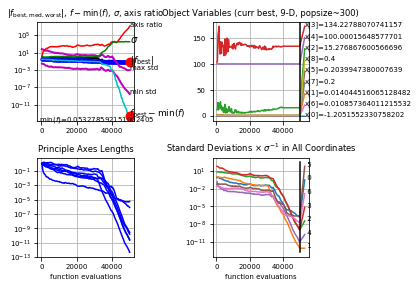

termination on tolconditioncov=100000000000000.0
final/bestever f-value = 5.327859e-02 5.327859e-02
incumbent solution: [-1.2053065043765625, 0.014044516865067514, 15.276868357733084, 134.22788305183926, 100.00015649649482, 0.2039992051447233, 0.01084913532810105, 0.2, 0.4]
std deviation: [0.00045144587415971046, 2.7516805673519083e-09, 3.304889925227994e-06, 3.7066217579796866e-06, 3.356158841434751e-08, 0.0008426350056311157, 5.2636824905424976e-05]


CMAEvolutionStrategyResult(xbest=array([-1.20515523e+00,  1.40445161e-02,  1.52768676e+01,  1.34227881e+02,
        1.00000156e+02,  2.03994738e-01,  1.08573640e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.053278592151002405, evals_best=49564, evaluations=49800, iterations=166, xfavorite=array([-1.20530650e+00, -1.02999088e-01,  1.52768684e+01,  1.34227883e+02,
        1.00000376e+02,  2.63762506e-01, -3.41859743e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.51445874e-04, 2.75168057e-09, 3.30488993e-06, 3.70662176e-06,
       3.35615884e-08, 8.42635006e-04, 5.26368249e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.20515523e+00  1.40445161e-02  1.52768676e+01  1.34227881e+02
  1.00000156e+02  2.03994738e-01  1.08573640e-02  2.00000000e-01
  4.00000000e-01]
error = 0.053278592151002405


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test27


9

21

321

Test: 28
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=743557, Sat May 22 08:07:02 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.343870572458637e-01 1.0e+00 9.32e-01  3e-02  6e+01 0:01.1
    2    600 3.260736436782324e-01 4.0e+00 9.36e-01  2e-02  5e+01 0:02.3
    3    900 3.168532088810063e-01 1.2e+01 9.19e-01  2e-02  5e+01 0:03.5
    6   1800 3.004866716156754e-01 3.9e+01 1.02e+00  2e-02  4e+01 0:07.1
   10   3000 3.009337961851519e-01 6.8e+01 1.30e+00  2e-02  2e+01 0:11.5
   15   4500 2.854931199445305e-01 8.6e+01 1.34e+00  2e-02  1e+01 0:17.5
   21   6300 2.548757756175473e-01 1.0e+02 1.67e+00  2e-02  8e+00 0:24.5
   28   8400 2.385051263168092e-01 9.6e+01 1.48e+00  2e-02  4e+00 0:32.6
   35  10500 2.300674870822895e-01 1.7e+02 1.56e+00  1e-02  3e+00 0:40.9
   43  12900 2.189735858139708e-01 1.4e+02 1.78e+00  9e-03  2e+00 0:50.3
   52  15600 2.212211985836146e-01 1.9e+02 2.01e+00  1e-02  4e+00 1:00.8
   62  18600 1.6802704

32

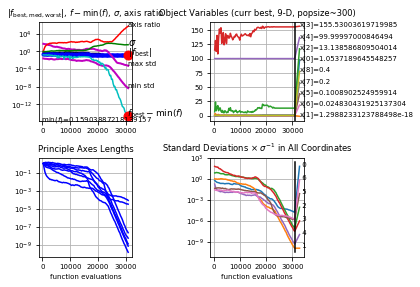

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.0535023796745329, 2.0154496997808098e-18, 13.138585904837315, 155.53003667520488, 99.99997001306697, 0.10093504585855918, 0.024846071412320543, 0.2, 0.4]
std deviation: [0.0005793925725816649, 4.920124205536058e-09, 3.220173344719038e-06, 1.2190841986839492e-06, 1.8755880349046714e-08, 5.430287737263263e-05, 5.9380359104125394e-05]


CMAEvolutionStrategyResult(xbest=array([1.05371896e+00, 1.29882331e-18, 1.31385868e+01, 1.55530036e+02,
       9.99999700e+01, 1.00890252e-01, 2.48304319e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.15903887218139157, evals_best=30834, evaluations=30900, iterations=103, xfavorite=array([ 1.05350238e+00, -4.99999994e-02, -3.73858590e+00,  1.55530037e+02,
        1.00000187e+02,  1.00935046e-01,  2.04926541e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([5.79392573e-04, 4.92012421e-09, 3.22017334e-06, 1.21908420e-06,
       1.87558803e-08, 5.43028774e-05, 5.93803591e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.05371896e+00 1.29882331e-18 1.31385868e+01 1.55530036e+02
 9.99999700e+01 1.00890252e-01 2.48304319e-02 2.00000000e-01
 4.00000000e-01]
error = 0.15903887218139157


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test28


9

21

321

Test: 29
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=732940, Sat May 22 08:09:04 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.463837315929180e-01 1.0e+00 1.05e+00  3e-02  6e+01 0:01.1
    2    600 3.061672980462416e-01 4.2e+00 1.10e+00  3e-02  6e+01 0:02.2
    3    900 3.394492816437021e-01 1.3e+01 1.10e+00  3e-02  6e+01 0:03.3
    6   1800 3.180653702856723e-01 5.4e+01 1.14e+00  1e-02  4e+01 0:06.6
   10   3000 3.078286026966675e-01 1.1e+02 1.12e+00  8e-03  2e+01 0:10.9
   15   4500 2.780994662921549e-01 2.3e+02 1.47e+00  8e-03  2e+01 0:16.8
   21   6300 2.314465607534153e-01 3.2e+02 1.33e+00  6e-03  7e+00 0:23.8
   28   8400 2.309466126228864e-01 3.1e+02 1.43e+00  6e-03  6e+00 0:31.7
   35  10500 2.146758263469026e-01 3.2e+02 1.43e+00  4e-03  3e+00 0:40.1
   43  12900 2.137131206491108e-01 4.0e+02 1.40e+00  4e-03  2e+00 0:49.6
   52  15600 1.908660139289826e-01 5.5e+02 3.42e+00  6e-03  3e+00 0:59.9
   62  18600 1.6398313

33

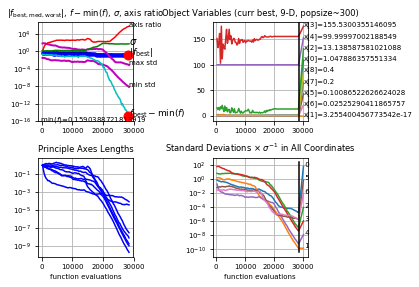

termination on tolfun=1e-11
final/bestever f-value = 1.590389e-01 1.590389e-01
incumbent solution: [1.048776935376825, 3.084366147312165e-18, 13.13858529390797, 155.5300368497694, 99.99997001490127, 0.10081255738252004, 0.025188231928436618, 0.2, 0.4]
std deviation: [0.0006636817978031755, 6.553390306240824e-09, 5.425441652854009e-06, 1.7499676749272517e-06, 2.5776770717435933e-08, 7.326717616752446e-05, 6.785559674673819e-05]


CMAEvolutionStrategyResult(xbest=array([1.04830266e+00, 2.35375005e-18, 1.31385841e+01, 1.55530037e+02,
       9.99999700e+01, 1.00812151e-01, 2.52226641e-02, 2.00000000e-01,
       4.00000000e-01]), fbest=0.1590388721813919, evals_best=28158, evaluations=28500, iterations=95, xfavorite=array([ 1.04877694e+00, -5.00000008e-02, -3.73858529e+00,  1.55530037e+02,
        1.00000187e+02,  4.27587443e-01,  2.09763791e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([6.63681798e-04, 6.55339031e-09, 5.42544165e-06, 1.74996767e-06,
       2.57767707e-08, 7.32671762e-05, 6.78555967e-05]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [1.04830266e+00 2.35375005e-18 1.31385841e+01 1.55530037e+02
 9.99999700e+01 1.00812151e-01 2.52226641e-02 2.00000000e-01
 4.00000000e-01]
error = 0.1590388721813919


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

187

0

0

0

0

0

0

0

end test29


9

21

321

Test: 30
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 7 (seed=746883, Sat May 22 08:10:56 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 3.341832162498918e-01 1.0e+00 9.52e-01  3e-02  5e+01 0:01.2
    2    600 2.896744619342738e-01 3.8e+00 9.02e-01  2e-02  5e+01 0:02.3
    3    900 3.207902608298667e-01 1.1e+01 8.74e-01  2e-02  4e+01 0:03.5
    6   1800 2.898140458450114e-01 3.8e+01 1.07e+00  2e-02  3e+01 0:06.9
   10   3000 2.586441313134069e-01 9.7e+01 1.23e+00  2e-02  2e+01 0:11.4
   15   4500 2.739103782611446e-01 9.3e+01 1.27e+00  1e-02  9e+00 0:17.4
   21   6300 2.198684806777897e-01 9.8e+01 1.41e+00  1e-02  8e+00 0:24.4
   28   8400 2.497716156703931e-01 8.4e+01 1.25e+00  1e-02  5e+00 0:32.3
   35  10500 2.126793083834559e-01 1.2e+02 1.17e+00  7e-03  7e+00 0:40.4
   43  12900 1.944954442970523e-01 1.7e+02 1.13e+00  5e-03  8e+00 0:49.7
   52  15600 1.228865701908623e-01 4.6e+02 1.19e+00  4e-03  1e+01 0:59.8
   62  18600 1.4344213

33

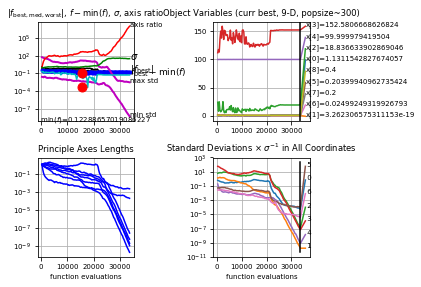

termination on tolfun=1e-11
final/bestever f-value = 1.744682e-01 1.228866e-01
incumbent solution: [1.1315538013522688, 1.726202940595e-19, 18.836634884156652, 152.580666021386, 99.99997941730439, 0.20395796312471115, 0.024973742030851866, 0.2, 0.4]
std deviation: [0.0015858583743311643, 5.169187944478857e-09, 3.5264032153804255e-06, 2.0303688547841695e-06, 2.469923635622771e-08, 0.002996158817595593, 0.0001052756093701315]


CMAEvolutionStrategyResult(xbest=array([-1.00704508e+00,  1.00971828e-02,  1.13653790e+01,  1.26612655e+02,
        1.00014725e+02,  1.68506958e-01,  1.58502248e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.12288657019086227, evals_best=15541, evaluations=33600, iterations=112, xfavorite=array([ 1.13155380e+00, -5.00000002e-02, -9.43663488e+00,  1.52580666e+02,
        1.00000197e+02,  2.61018416e-01,  2.06735340e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([1.58585837e-03, 5.16918794e-09, 3.52640322e-06, 2.03036885e-06,
       2.46992364e-08, 2.99615882e-03, 1.05275609e-04]))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-1.00704508e+00  1.00971828e-02  1.13653790e+01  1.26612655e+02
  1.00014725e+02  1.68506958e-01  1.58502248e-02  2.00000000e-01
  4.00000000e-01]
error = 0.12288657019086227


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rps)')

196

0

0

0

0

0

0

0

end test30


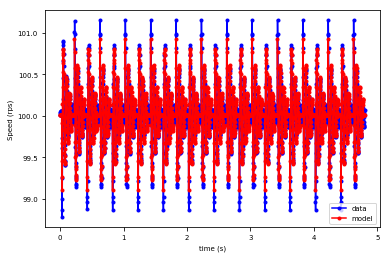

In [11]:
for test in range(30):
    
    # write report.txt file
    file_report  = open(results_dir+"/Report_"+str(test+1)+".txt", "w") 
    file_report.write("\nTest: "+str(test+1));
    file_report.write("\nProblem dimension: "+str(dim));
    file_report.write("\nParameter bounds: "+str(domain));
    #file_report.write("\nCMA-ES settings: Popsize=" +str(popsize)+" - Iterations="+str(iterations))
    
    print ("Test: "+str(test+1))
    tic = time.time()
    
   # 'repetitive' pattern identification

    #x0 = (m+M)/2
    #sigma0 = (M-m)/4
    x0 = (domain[0]+domain[1])/2
    sigma0 = (domain[1]-domain[0])/4    


    #res = cma.CMAEvolutionStrategy(x0, 1, inopts={'popsize':2000, 'CMA_stds':sigma0,'fixed_variables':{5:0.218, 6:0, 7:0.204}}) 
    res = cma.CMAEvolutionStrategy(x0, 1, inopts = {'popsize':300, 'CMA_stds':sigma0, 'bounds':[domain[0], domain[1]], 'fixed_variables':{ 7:0.20, 8:0.4}}) 
    res.optimize(obj, iterations=200) 
    
    elapsed_time = time.time() - tic
    file_report.write("\nElapsed time: "+str(elapsed_time));
    
    %matplotlib inline
    cma.plot()
    
    res.result_pretty()
    
    out_1 = res.result.xbest

    print('out = [A, t0, tau, omega, c, t1, t2, T] =' ) 
    print('    =', out_1)
    print('error =', obj(out_1))

    # plot resulting function

    [A, t0, tau, omega, c, t1, t2, T, TT] = out_1

    ##plt.plot(t, h(out), '-ro')
    plt.plot(t, v, '-b.', t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.')
    plt.xlabel('time (s)')
    plt.ylabel('Speed (rps)') 
    plt.legend(['data','model'])
    #plt.show()
    plt.savefig(results_dir+'/test'+str(test+1), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    plt.savefig(results_dir+'/test'+str(test+1)+'.pdf')
    
    #baklash_est_1 = abs(out_1[0])
    #baklash_est_1
    file_report.write("\nResults: [A, t0, tau, omega, c, t1, t2, T, TT]= "+str(out_1));
    #file_report.write("\n")
    file_report.close()


    for elem in range(7):
        worksheet.write_number(test,elem, out_1[elem] );
    
    
    print("end test"+str(test+1))
    
workbook.close()